In [2]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from sklearn.cluster import DBSCAN
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.offline as py

try:
    import obspy
except:
    !pip install obspy
from obspy.imaging.beachball import beach

In [3]:
from copy import copy

In [4]:
## Load files and switch Eastings and Northings

focal_50 = np.genfromtxt('50Focal_Mechanisms.csv', dtype = float, delimiter=',')
focal_50[:, [0,1]] = focal_50[:, [1,0]]
focal_50 = np.delete(focal_50, 3, 1)

refined_3a = np.genfromtxt('refined_3a.csv', dtype = float, delimiter=',')
refined_3a[:, [0,1]] = refined_3a[:, [1,0]]
refined_3a = np.delete(refined_3a, 3, 1)

refined_4a = np.genfromtxt('refined_4a.csv', dtype = float, delimiter=',')
refined_4a[:, [0,1]] = refined_4a[:, [1,0]]
refined_4a = np.delete(refined_4a, 3, 1)

refined_4b = np.genfromtxt('refined_4b.csv', dtype = float, delimiter=',')
refined_4b[:, [0,1]] = refined_4b[:, [1,0]]
refined_4b = np.delete(refined_4b, 3, 1)

refined_5a = np.genfromtxt('refined_5a.csv', dtype = float, delimiter=',')
refined_5a[:, [0,1]] = refined_5a[:, [1,0]]
refined_5a = np.delete(refined_5a, 3, 1)

refined_6ai = np.genfromtxt('refined_6ai.csv', dtype = float, delimiter=',')
refined_6ai[:, [0,1]] = refined_6ai[:, [1,0]]
refined_6ai = np.delete(refined_6ai, 3, 1)

refined_6aii = np.genfromtxt('refined_6aii.csv', dtype = float, delimiter=',')
refined_6aii[:, [0,1]] = refined_6aii[:, [1,0]]
refined_6aii = np.delete(refined_6aii, 3, 1)

refined_7ai = np.genfromtxt('refined_7ai.csv', dtype = float, delimiter=',')
refined_7ai[:, [0,1]] = refined_7ai[:, [1,0]]
refined_7ai = np.delete(refined_7ai, 3, 1)

refined_7aii = np.genfromtxt('refined_7aii.csv', dtype = float, delimiter=',')
refined_7aii[:, [0,1]] = refined_7aii[:, [1,0]]
refined_7aii = np.delete(refined_7aii, 3, 1)

refined_7aiii = np.genfromtxt('refined_7aiii.csv', dtype = float, delimiter=',')
refined_7aiii[:, [0,1]] = refined_7aiii[:, [1,0]]
refined_7aiii = np.delete(refined_7aiii, 3, 1)

refined_7aiv = np.genfromtxt('refined_7aiv.csv', dtype = float, delimiter=',')
refined_7aiv[:, [0,1]] = refined_7aiv[:, [1,0]]
refined_7aiv = np.delete(refined_7aiv, 3, 1)

refined_7c = np.genfromtxt('refined_7c.csv', dtype = float, delimiter=',')
refined_7c[:, [0,1]] = refined_7c[:, [1,0]]
refined_7c = np.delete(refined_7c, 3, 1)

refined_7d = np.genfromtxt('refined_7d.csv', dtype = float, delimiter=',')
refined_7d[:, [0,1]] = refined_7d[:, [1,0]]
refined_7d = np.delete(refined_7d, 3, 1)

refined_7e = np.genfromtxt('refined_7e.csv', dtype = float, delimiter=',')
refined_7e[:, [0,1]] = refined_7e[:, [1,0]]
refined_7e = np.delete(refined_7e, 3, 1)

refined_8a = np.genfromtxt('refined_8a.csv', dtype = float, delimiter=',')
refined_8a[:, [0,1]] = refined_8a[:, [1,0]]
refined_8a = np.delete(refined_8a, 3, 1)

refined_8b = np.genfromtxt('refined_8b.csv', dtype = float, delimiter=',')
refined_8b[:, [0,1]] = refined_8b[:, [1,0]]
refined_8b = np.delete(refined_8b, 3, 1)

refined_9a = np.genfromtxt('refined_9a.csv', dtype = float, delimiter=',')
refined_9a[:, [0,1]] = refined_9a[:, [1,0]]
refined_9a = np.delete(refined_9a, 3, 1)

refined_9b = np.genfromtxt('refined_9b.csv', dtype = float, delimiter=',')
refined_9b[:, [0,1]] = refined_9b[:, [1,0]]
refined_9b = np.delete(refined_9b, 3, 1)

refined_10a = np.genfromtxt('refined_10a.csv', dtype = float, delimiter=',')
refined_10a[:, [0,1]] = refined_10a[:, [1,0]]
refined_10a = np.delete(refined_10a, 3, 1)

### Assign Focal Mechanisms to Each Cluster

In [5]:
def compute_plane_normal(strike, dip):
    """
    Compute the normal vector of a plane given strike and dip.
    """
    # Convert strike and dip to radians
    strike_rad = np.radians(strike)
    dip_rad = np.radians(dip)

    # Calculate normal vector components
    n_x = np.sin(dip_rad) * np.sin(strike_rad)
    n_y = np.sin(dip_rad) * np.cos(strike_rad)
    n_z = np.cos(dip_rad)

    return n_x, n_y, n_z

In [6]:
def plot_3d_plane_plotly(centers, normals, points, cluster_labels, cluster_name):
    # fig = go.Figure()

    # Plot points for each cluster
    unique_labels = set(cluster_labels)
    for label in unique_labels:
        if label == -1:  # Skip noise
            continue

        fig = go.Figure()
        cluster_mask = (cluster_labels == label)
        cluster_points = points[cluster_mask]
        fig.add_trace(go.Scatter3d(x=cluster_points[:, 0], y=cluster_points[:, 1], z=cluster_points[:, 2],
                                  mode='markers', name=f'Cluster {label}',
                                  marker=dict(size=5)))

        # Plot the plane for each cluster
        center = centers[label]
        normal = normals[label]

        d = -np.dot(center, normal)
        xx, yy = np.meshgrid(np.linspace(cluster_points[:, 0].min()-10, cluster_points[:, 0].max()+10, 10),
                            np.linspace(cluster_points[:, 1].min()-10, cluster_points[:, 1].max()+10, 10))
        zz = (-normal[0] * xx - normal[1] * yy - d) / normal[2]
        fig.add_trace(go.Surface(x=xx, y=yy, z=zz, name=f'Plane_{label}', opacity=0.5, showscale=False))

        # Update layout
        fig.update_layout(title='Fault Plane of ' + cluster_name + f' Subcluster {label} Focal Mechanisms',
                          scene=dict(xaxis_title='Easting [ft]', yaxis_title='Northing [ft]', zaxis_title='Depth [ft]'),
                          legend_title="Legend")
        # fig.show()
        fig.write_html(cluster_name + f" Subcluster {label}.html")

In [80]:
def assign_focal_mechanisms_to_cluster_plotly(points, focal_mechanisms, threshold=1000, eps = 0.5, min_samples=5, cluster_name='Cluster 3a'):

    # Step 1: Assign focal mechanisms to the points

    # Calculate distances between points and focal mechanisms
    distances = cdist(points[:, :3], focal_mechanisms[:, :3])

    # Identify focal mechanisms within the cluster based on the threshold
    within_threshold_indices = np.any(distances <= threshold, axis=0)
    within_cluster_fms = focal_mechanisms[within_threshold_indices]
    print('Known Focal mechanisms within ' + cluster_name + ':')
    for i in range(len(within_cluster_fms)):
      print(f'Strike: {within_cluster_fms[i,3]}, Dip: {within_cluster_fms[i,4]}, Rake: {within_cluster_fms[i,5]}')
    print('----------------------------------------------------------')

    if len(within_cluster_fms) == 0:
        # If no focal mechanisms are found within the cluster, return the points as they are
        return points

    if len(within_cluster_fms) == 1:
        # If only one focal mechanism, assign it to all points
        assigned_fms = np.tile(within_cluster_fms[0, 3:], (len(points), 1))
        cluster_labels = np.zeros(len(points), dtype=int)  # Single cluster
    else:
        # More than one focal mechanism found, perform linear interpolation for focal mechanisms
        fm_coords = within_cluster_fms[:, :3]
        fm_values = within_cluster_fms[:, 3:]
        interpolated_fms = np.zeros((len(points), 3))  # Prepare array for interpolated values

        for i in range(3):  # Interpolate each component of the focal mechanism separately
            # First attempt linear interpolation
            temp_interpolated = griddata(fm_coords, fm_values[:, i], points[:, :3], method='linear')

            # Check for nan values and apply 'nearest' for those points
            nan_indices = np.isnan(temp_interpolated)
            if np.any(nan_indices):
                temp_interpolated[nan_indices] = griddata(fm_coords, fm_values[:, i], points[nan_indices, :3], method='nearest')

            interpolated_fms[:, i] = temp_interpolated

        assigned_fms = interpolated_fms
        # Step 2: Sub-cluster based on assigned focal mechanisms using DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(assigned_fms)
        cluster_labels = clustering.labels_

    # Append the assigned or interpolated focal mechanisms to the seismic points data
    assigned_points = np.hstack((points, assigned_fms))

    # Step 3: Compute Fault Plane and plot it
    centers = {}
    normals = {}
    beachballs = []

    unique_labels = set(cluster_labels)
    for label in unique_labels:
        if label == -1:
            continue

        class_member_mask = (cluster_labels == label)
        cluster_points = points[class_member_mask]
        centroid = np.mean(cluster_points, axis=0)
        avg_focal_mechanism = np.mean(assigned_points[class_member_mask, 3:], axis=0)

        beachball = np.concatenate((centroid, avg_focal_mechanism))
        beachballs.append(beachball)
        print(f'Identified New Focal Mechanisms for subcluster {label} are Strike: {avg_focal_mechanism[0]:.0f}, Dip: {avg_focal_mechanism[1]:.0f}, Rake: {avg_focal_mechanism[2]:.0f} ')
        avg_strike, avg_dip = avg_focal_mechanism[:2]
        normal = compute_plane_normal(avg_strike, avg_dip)

        centers[label] = centroid
        normals[label] = normal


    # Convert dictionaries to numpy arrays and concatenate
    normals_array = np.array(list(normals.values()))
    centers_array = np.array(list(centers.values()))
    beachballs = np.array(beachballs)

    combined_planes = np.concatenate((centers_array, normals_array, beachballs[:, 3:]), axis=1)

    # Use Plotly to visualize the planes and points
    plot_3d_plane_plotly(centers, normals, points, cluster_labels, cluster_name)


    return assigned_points, cluster_labels, beachballs, combined_planes

In [81]:
fm_3a_plotly, _ , beachballs_3a, planes_3a  = assign_focal_mechanisms_to_cluster_plotly(refined_3a, focal_50, threshold=1000, cluster_name='Cluster 3a')

Known Focal mechanisms within Cluster 3a:
Strike: 45.0, Dip: 85.0, Rake: 0.0
Strike: 106.0, Dip: 57.0, Rake: 77.0
Strike: 76.0, Dip: 85.0, Rake: 15.0
Strike: 45.0, Dip: 85.0, Rake: -5.0
Strike: 78.0, Dip: 81.0, Rake: 20.0
Strike: 245.0, Dip: 85.0, Rake: 5.0
Strike: 106.0, Dip: 52.0, Rake: 63.0
Strike: 250.0, Dip: 90.0, Rake: -15.0
Strike: 95.0, Dip: 65.0, Rake: 35.0
Strike: 80.0, Dip: 85.0, Rake: 15.0
Strike: 75.0, Dip: 90.0, Rake: 25.0
Strike: 45.0, Dip: 85.0, Rake: 0.0
Strike: 270.0, Dip: 80.0, Rake: 15.0
Strike: 80.0, Dip: 85.0, Rake: 20.0
Strike: 45.0, Dip: 90.0, Rake: -5.0
Strike: 50.0, Dip: 90.0, Rake: 0.0
Strike: 75.0, Dip: 90.0, Rake: 20.0
Strike: 85.0, Dip: 90.0, Rake: 25.0
Strike: 225.0, Dip: 35.0, Rake: 70.0
Strike: 250.0, Dip: 85.0, Rake: -20.0
Strike: 255.0, Dip: 90.0, Rake: -20.0
Strike: 225.0, Dip: 90.0, Rake: 5.0
Strike: 95.0, Dip: 60.0, Rake: 50.0
Strike: 235.0, Dip: 75.0, Rake: 0.0
Strike: 225.0, Dip: 90.0, Rake: 5.0
Strike: 270.0, Dip: 20.0, Rake: 120.0
Strike: 265.0

In [82]:
fm_4a_plotly, _, beachballs_4a, planes_4a = assign_focal_mechanisms_to_cluster_plotly(refined_4a, focal_50, threshold=1000, cluster_name='Cluster 4a')

Known Focal mechanisms within Cluster 4a:
Strike: 45.0, Dip: 60.0, Rake: 95.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 45, Dip: 60, Rake: 95 


In [83]:
fm_4b_plotly, _, beachballs_4b, planes_4b = assign_focal_mechanisms_to_cluster_plotly(refined_4b, focal_50, threshold=1000, cluster_name='Cluster 4b')

Known Focal mechanisms within Cluster 4b:
Strike: 45.0, Dip: 60.0, Rake: 95.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 45, Dip: 60, Rake: 95 


In [84]:
fm_5a_plotly, _, beachballs_5a, planes_5a = assign_focal_mechanisms_to_cluster_plotly(refined_5a, focal_50, threshold=3000, cluster_name='Cluster 5a')

Known Focal mechanisms within Cluster 5a:
Strike: 76.0, Dip: 71.0, Rake: 66.0
Strike: 90.0, Dip: 71.0, Rake: 16.0
Strike: 45.0, Dip: 60.0, Rake: 95.0
Strike: 45.0, Dip: 85.0, Rake: 0.0
Strike: 106.0, Dip: 57.0, Rake: 77.0
Strike: 76.0, Dip: 85.0, Rake: 15.0
Strike: 45.0, Dip: 85.0, Rake: -5.0
Strike: 78.0, Dip: 81.0, Rake: 20.0
Strike: 245.0, Dip: 85.0, Rake: 5.0
Strike: 106.0, Dip: 52.0, Rake: 63.0
Strike: 250.0, Dip: 90.0, Rake: -15.0
Strike: 95.0, Dip: 65.0, Rake: 35.0
Strike: 80.0, Dip: 85.0, Rake: 15.0
Strike: 75.0, Dip: 90.0, Rake: 25.0
Strike: 45.0, Dip: 85.0, Rake: 0.0
Strike: 270.0, Dip: 80.0, Rake: 15.0
Strike: 80.0, Dip: 85.0, Rake: 20.0
Strike: 45.0, Dip: 90.0, Rake: -5.0
Strike: 50.0, Dip: 90.0, Rake: 0.0
Strike: 75.0, Dip: 90.0, Rake: 20.0
Strike: 85.0, Dip: 90.0, Rake: 25.0
Strike: 225.0, Dip: 35.0, Rake: 70.0
Strike: 250.0, Dip: 85.0, Rake: -20.0
Strike: 255.0, Dip: 90.0, Rake: -20.0
Strike: 225.0, Dip: 90.0, Rake: 5.0
Strike: 95.0, Dip: 60.0, Rake: 50.0
Strike: 235.0, 

In [85]:
fm_6ai_plotly, _, beachballs_6ai, planes_6ai = assign_focal_mechanisms_to_cluster_plotly(refined_6ai, focal_50, threshold=1000, cluster_name='Cluster 6ai')

Known Focal mechanisms within Cluster 6ai:
Strike: 105.0, Dip: 30.0, Rake: 90.0
Strike: 90.0, Dip: 85.0, Rake: -25.0
Strike: 255.0, Dip: 60.0, Rake: 50.0
Strike: 260.0, Dip: 65.0, Rake: 50.0
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 255, Dip: 60, Rake: 50 
Identified New Focal Mechanisms for subcluster 1 are Strike: 260, Dip: 65, Rake: 50 
Identified New Focal Mechanisms for subcluster 2 are Strike: 90, Dip: 85, Rake: -25 
Identified New Focal Mechanisms for subcluster 3 are Strike: 105, Dip: 30, Rake: 90 


In [86]:
fm_6aii_plotly, _, beachballs_6aii, planes_6aii = assign_focal_mechanisms_to_cluster_plotly(refined_6aii, focal_50, threshold=1000, cluster_name='Cluster 6aii')

Known Focal mechanisms within Cluster 6aii:
Strike: 105.0, Dip: 30.0, Rake: 90.0
Strike: 90.0, Dip: 85.0, Rake: -25.0
Strike: 255.0, Dip: 60.0, Rake: 50.0
Strike: 260.0, Dip: 65.0, Rake: 50.0
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 289, Dip: 78, Rake: -144 
Identified New Focal Mechanisms for subcluster 1 are Strike: 260, Dip: 65, Rake: 50 
Identified New Focal Mechanisms for subcluster 2 are Strike: 265, Dip: 75, Rake: 10 
Identified New Focal Mechanisms for subcluster 3 are Strike: 255, Dip: 60, Rake: 50 


In [87]:
fm_7ai_plotly, _, beachballs_7ai, planes_7ai = assign_focal_mechanisms_to_cluster_plotly(refined_7ai, focal_50, threshold=2000, cluster_name='Cluster 7ai')

Known Focal mechanisms within Cluster 7ai:
Strike: 90.0, Dip: 85.0, Rake: -25.0
Strike: 255.0, Dip: 60.0, Rake: 50.0
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 


In [88]:
fm_7aii_plotly, _, beachballs_7aii, planes_7aii = assign_focal_mechanisms_to_cluster_plotly(refined_7aii, focal_50, threshold=1000, cluster_name='Cluster 7aii')

Known Focal mechanisms within Cluster 7aii:
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 


In [89]:
fm_7aiii_plotly, _, beachballs_7aiii, planes_7aiii = assign_focal_mechanisms_to_cluster_plotly(refined_7aiii, focal_50, threshold=1000, cluster_name='Cluster 7aiii')

Known Focal mechanisms within Cluster 7aiii:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 


In [90]:
fm_7aiv_plotly, _, beachballs_7aiv, planes_7aiv = assign_focal_mechanisms_to_cluster_plotly(refined_7aiv, focal_50, threshold=1000, cluster_name='Cluster 7aiv')

Known Focal mechanisms within Cluster 7aiv:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 
Identified New Focal Mechanisms for subcluster 1 are Strike: 220, Dip: 60, Rake: 15 
Identified New Focal Mechanisms for subcluster 2 are Strike: 201, Dip: 64, Rake: -46 
Identified New Focal Mechanisms for subcluster 3 are Strike: 289, Dip: 78, Rake: -144 
Identified New Focal Mechanisms for subcluster 4 are Strike: 277, Dip: 65, Rake: -174 
Identified New Focal Mechanisms for subcluster 5 are Strike: 285, Dip: 75, Rake: -160 


In [91]:
fm_7c_plotly, _, beachballs_7c, planes_7c = assign_focal_mechanisms_to_cluster_plotly(refined_7c, focal_50, threshold=1000, cluster_name='Cluster 7c')

Known Focal mechanisms within Cluster 7c:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 289, Dip: 78, Rake: -144 
Identified New Focal Mechanisms for subcluster 1 are Strike: 220, Dip: 60, Rake: 15 


In [92]:
fm_7d_plotly, _, beachballs_7d, planes_7d = assign_focal_mechanisms_to_cluster_plotly(refined_7d, focal_50, threshold=2000, cluster_name='Cluster 7d')

Known Focal mechanisms within Cluster 7d:
Strike: 90.0, Dip: 85.0, Rake: -25.0
Strike: 255.0, Dip: 60.0, Rake: 50.0
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 


In [93]:
fm_7e_plotly, _, beachballs_7e, planes_7e = assign_focal_mechanisms_to_cluster_plotly(refined_7e, focal_50, threshold=2000, cluster_name='Cluster 7e')

Known Focal mechanisms within Cluster 7e:
Strike: 90.0, Dip: 85.0, Rake: -25.0
Strike: 255.0, Dip: 60.0, Rake: 50.0
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 280, Dip: 80, Rake: -165 


In [94]:
fm_8a_plotly, _, beachballs_8a, planes_8a = assign_focal_mechanisms_to_cluster_plotly(refined_8a, focal_50, threshold=4000, cluster_name='Cluster 8a')

Known Focal mechanisms within Cluster 8a:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 225, Dip: 90, Rake: -175 


In [95]:
fm_8b_plotly, _, beachballs_8b, planes_8b = assign_focal_mechanisms_to_cluster_plotly(refined_8b, focal_50, threshold=2000, cluster_name='Cluster 8b')

Known Focal mechanisms within Cluster 8b:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 225, Dip: 90, Rake: -175 
Identified New Focal Mechanisms for subcluster 1 are Strike: 289, Dip: 78, Rake: -144 


In [96]:
fm_9a_plotly, _, beachballs_9a, planes_9a = assign_focal_mechanisms_to_cluster_plotly(refined_9a, focal_50, threshold=3000, cluster_name='Cluster 9a')

Known Focal mechanisms within Cluster 9a:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 78, Dip: 28, Rake: 47 


In [97]:
fm_9b_plotly, _, beachballs_9b, planes_9b = assign_focal_mechanisms_to_cluster_plotly(refined_9b, focal_50, threshold=4000, cluster_name='Cluster 9b')

Known Focal mechanisms within Cluster 9b:
Strike: 289.0, Dip: 78.0, Rake: -144.0
Strike: 201.0, Dip: 64.0, Rake: -46.0
Strike: 285.0, Dip: 75.0, Rake: -160.0
Strike: 280.0, Dip: 80.0, Rake: -165.0
Strike: 277.0, Dip: 65.0, Rake: -174.0
Strike: 220.0, Dip: 60.0, Rake: 15.0
Strike: 225.0, Dip: 90.0, Rake: -175.0
Strike: 265.0, Dip: 75.0, Rake: 10.0
Strike: 78.0, Dip: 28.0, Rake: 47.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 78, Dip: 28, Rake: 47 


In [98]:
fm_10_plotly, _, beachballs_10, planes_10a = assign_focal_mechanisms_to_cluster_plotly(refined_10a, focal_50, threshold=1000, cluster_name='Cluster 10a')

Known Focal mechanisms within Cluster 10a:
Strike: 90.0, Dip: 85.0, Rake: -25.0
----------------------------------------------------------
Identified New Focal Mechanisms for subcluster 0 are Strike: 90, Dip: 85, Rake: -25 


In [100]:
all_identified_planes = np.concatenate((planes_3a, planes_4a, planes_4b, planes_5a, planes_6ai, planes_6aii,
                                       planes_7ai, planes_7aii, planes_7aiii, planes_7aiv, planes_7c,
                                       planes_7d, planes_7e, planes_8a, planes_8b, planes_9a, planes_9b, planes_10a))

In [101]:
np.savetxt("all_identified_planes.csv", all_identified_planes, delimiter=",")

In [102]:
all_identified_beachballs = np.concatenate((beachballs_3a, beachballs_4a, beachballs_4b, beachballs_5a, beachballs_6ai,
                                            beachballs_6aii, beachballs_7ai, beachballs_7aii, beachballs_7aiii, beachballs_7aiv,
                                            beachballs_7c, beachballs_7d, beachballs_7e, beachballs_8a, beachballs_8b,
                                            beachballs_9a, beachballs_9b, beachballs_10))

In [103]:
known_FM = {}
# for i in range(50, len(data_list)):
for i in range(0,50):
    s = [int(focal_50[i][3]), int(focal_50[i][4]), int(focal_50[i][5])]
    known_FM['beach'+str(i)] = beach(s, linewidth=0.25, facecolor='b',xy=(float(focal_50[i][0]), float(focal_50[i][1])), width=200)

In [104]:
identified_FM = {}
# for i in range(50, len(data_list)):
for i in range(0, len(all_identified_beachballs)):
    s = [int(all_identified_beachballs[i][3]), int(all_identified_beachballs[i][4]), int(all_identified_beachballs[i][5])]
    identified_FM['beach'+str(i)] = beach(s, linewidth=0.25, facecolor='r',xy=(float(all_identified_beachballs[i][0]), float(all_identified_beachballs[i][1])), width=200)

Text(0.5, 1.0, 'New and Known Focal Mechanisms')

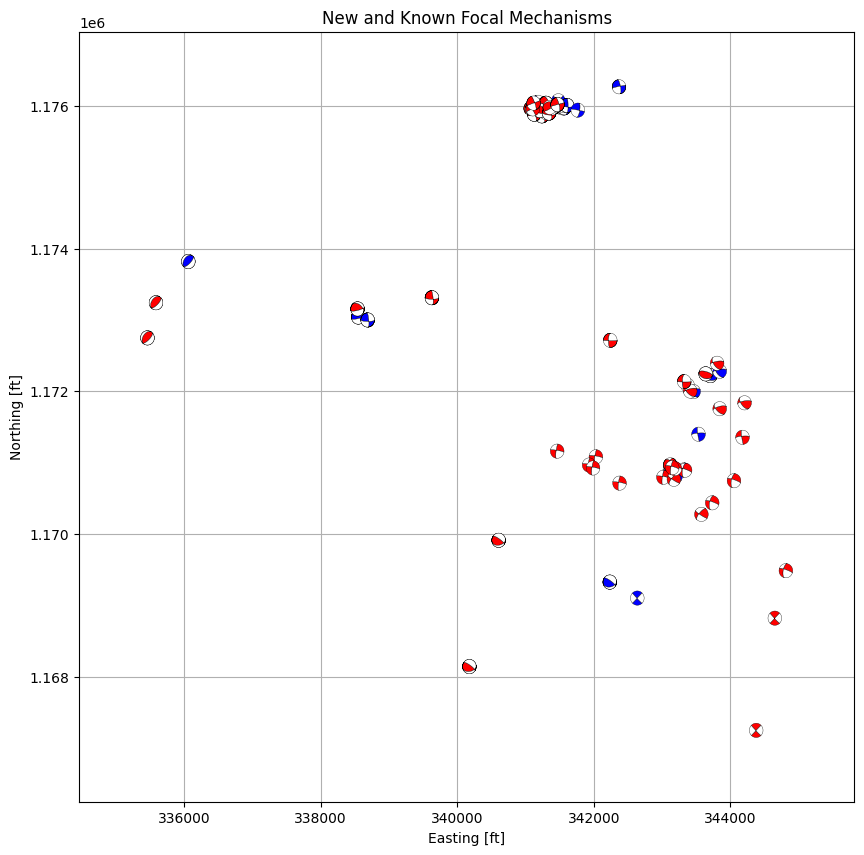

In [105]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.gca()
for i in range(0,50):
  known_FM_copy = copy(known_FM['beach'+str(i)])
  ax.add_collection(known_FM_copy)

for i in range(0,len(all_identified_beachballs)):
  identified_FM_copy = copy(identified_FM['beach'+str(i)])
  ax.add_collection(identified_FM_copy)

# ax.set_aspect("equal")
ax.set_xlim((np.min(all_identified_beachballs[:,0])-1000, np.max(all_identified_beachballs[:,0])+1000))
ax.set_ylim((np.min(all_identified_beachballs[:,1])-1000, np.max(all_identified_beachballs[:,1])+1000))
plt.grid()
plt.xlabel('Easting [ft]')
plt.ylabel('Northing [ft]')
plt.title("New and Known Focal Mechanisms")

Text(0.5, 1.0, 'Seismic Events with New and Known Focal Mechanisms')

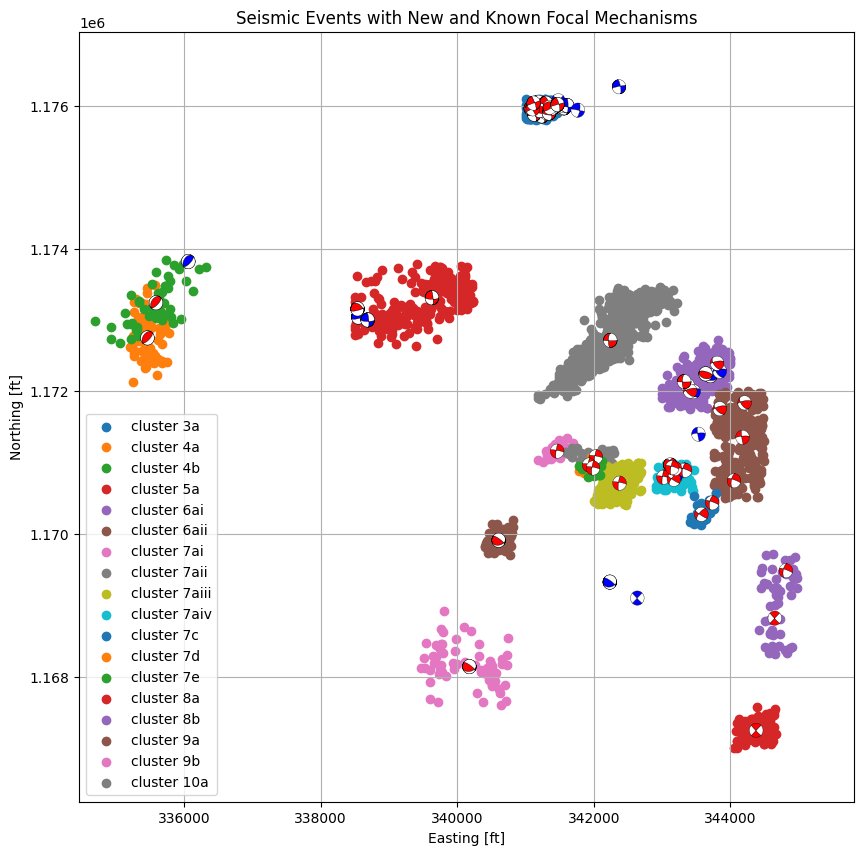

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.gca()
for i in range(0,50):
  known_FM_copy = copy(known_FM['beach'+str(i)])
  ax.add_collection(known_FM_copy)

for i in range(0,len(all_identified_beachballs)):
  identified_FM_copy = copy(identified_FM['beach'+str(i)])
  ax.add_collection(identified_FM_copy)

ax.scatter(refined_3a[:,0], refined_3a[:,1], label = 'cluster 3a')
ax.scatter(refined_4a[:,0], refined_4a[:,1], label = 'cluster 4a')
ax.scatter(refined_4b[:,0], refined_4b[:,1], label = 'cluster 4b')
ax.scatter(refined_5a[:,0], refined_5a[:,1], label = 'cluster 5a')
ax.scatter(refined_6ai[:,0], refined_6ai[:,1], label = 'cluster 6ai')
ax.scatter(refined_6aii[:,0], refined_6aii[:,1], label = 'cluster 6aii')
ax.scatter(refined_7ai[:,0], refined_7ai[:,1], label = 'cluster 7ai')
ax.scatter(refined_7aii[:,0], refined_7aii[:,1], label = 'cluster 7aii')
ax.scatter(refined_7aiii[:,0], refined_7aiii[:,1], label = 'cluster 7aiii')
ax.scatter(refined_7aiv[:,0], refined_7aiv[:,1], label = 'cluster 7aiv')
ax.scatter(refined_7c[:,0], refined_7c[:,1], label = 'cluster 7c')
ax.scatter(refined_7d[:,0], refined_7d[:,1], label = 'cluster 7d')
ax.scatter(refined_7e[:,0], refined_7e[:,1], label = 'cluster 7e')
ax.scatter(refined_8a[:,0], refined_8a[:,1], label = 'cluster 8a')
ax.scatter(refined_8b[:,0], refined_8b[:,1], label = 'cluster 8b')
ax.scatter(refined_9a[:,0], refined_9a[:,1], label = 'cluster 9a')
ax.scatter(refined_9b[:,0], refined_9b[:,1], label = 'cluster 9b')
ax.scatter(refined_10a[:,0], refined_10a[:,1], label = 'cluster 10a')

# ax.set_aspect("equal")
ax.set_xlim((np.min(all_identified_beachballs[:,0])-1000, np.max(all_identified_beachballs[:,0])+1000))
ax.set_ylim((np.min(all_identified_beachballs[:,1])-1000, np.max(all_identified_beachballs[:,1])+1000))
plt.grid()
plt.legend()
plt.xlabel('Easting [ft]')
plt.ylabel('Northing [ft]')
plt.title("Seismic Events with New and Known Focal Mechanisms")

Text(0.5, 1.0, 'Known Focal Mechanisms from SLB')

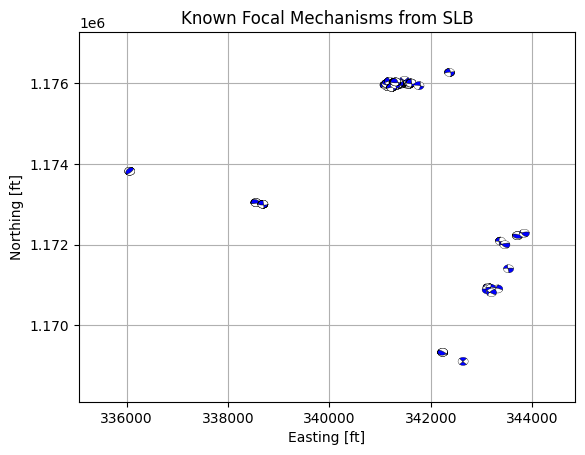

In [107]:
fig, ax = plt.subplots()
ax = plt.gca()
for i in range(0,50):
  known_FM_copy = copy(known_FM['beach'+str(i)])
  ax.add_collection(known_FM_copy)

# ax.set_aspect("equal")
ax.set_xlim((np.min(focal_50[:,0])-1000, np.max(focal_50[:,0])+1000))
ax.set_ylim((np.min(focal_50[:,1])-1000, np.max(focal_50[:,1])+1000))
plt.grid()
plt.xlabel('Easting [ft]')
plt.ylabel('Northing [ft]')
plt.title("Known Focal Mechanisms from SLB")